In [1]:
import json

In [2]:
from ipynb.fs.full.quantumsystem import QuantumSystem, qs

In [3]:
class XYLocation(QuantumSystem.System):
    @classmethod
    def get_relationship(cls, entity_id):
        return json.loads(super().get_relationship(entity_id))

    @classmethod
    def validate(cls, terminant):
        if len(terminant) != 2:
            raise Exception(f"Unrecognized terminant: {terminant}")
        return json.dumps([int(d) for d in terminant])
    
    @classmethod
    def origin(cls):
        return (0, 0)

In [4]:
class Elevation(QuantumSystem.System):
    @classmethod
    def get_relationship(cls, entity_id):
        return int(super().get_relationship(entity_id))
        
    @classmethod
    def validate(cls, terminant):
        return str(int(terminant))

In [5]:
class MovementSpeed(QuantumSystem.System):
    """ Movement Speed Value """
    @classmethod
    def get_relationship(cls, entity_id):
        return int(super().get_relationship(entity_id))
        
    @classmethod
    def validate(cls, terminant):
        return str(int(terminant))

class JumpJets(QuantumSystem.System):
    """ Jump Jets """
    
    @classmethod
    def has_jump_jets(cls, unit):
        return cls.get_relationship(unit) == 'j'
    
    @classmethod
    def validate(cls, terminant):
        if terminant not in ['', None, 'j']:
            raise Exception(f"Invalid JumpJets terminant: {terminant}")
        return terminant

In [6]:
@JumpJets.sd
@MovementSpeed.sd
class Movement(QuantumSystem.HyperSystem):
    @classmethod
    def has_jump_jets(cls, unit):
        return JumpJets.has_jump_jets(unit)
    
    @classmethod
    def get_movement_speed(cls, unit):
        return int(MovementSpeed.get_relationship(unit))

In [7]:
@XYLocation.sd
@Elevation.sd
@Movement.sd
class Move(QuantumSystem.HyperSystem):
    @classmethod
    @Elevation.d
    @XYLocation.d
    @Movement.MovementSpeed.d
    def move(cls, entity_id, delta, movementspeed, xylocation, elevation):
        xyz = json.dumps(xylocation + [elevation])
        deltaDistance = sum([d * d for d in delta]) ** 0.5
        assert deltaDistance < movementspeed, f"Cannot move unit further ({deltaDistance}) than its movement speed ({movementspeed})"
        newLocation = [sL + lD for sL, lD in zip(json.loads(xyz), delta)]
        xy = newLocation[:2]
        z = newLocation[2]
        XYLocation.set_relationship(entity_id, xy)
        Elevation.set_relationship(entity_id, z)

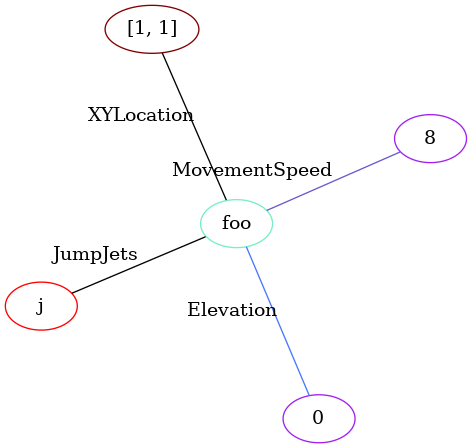

In [8]:
if __name__ == "__main__":
    from IPython.display import display
    qs.reset()
    Move.build_system("foo", {"XYLocation": [1, 1], "Elevation": 0, "Movement": (8, "j")})
    display(qs.render())

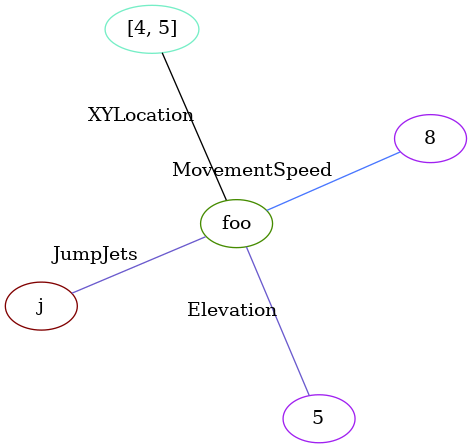

In [9]:
if __name__ == "__main__":
    Move.move(entity_id="foo", delta=[3, 4, 5])
    display(qs.render())